In [1]:
import os
os.chdir("/home/studio-lab-user/sagemaker-studiolab-notebooks/AI-OT-24/Reinforcement-Learning-Stock-Porfolio-Managment")
!pip install -q -r requirements.txt
import sys
sys.path.append('./utils')
from trading_functions import *
# Core Libraries
import os
import sys
import time
import datetime
import warnings
import itertools
#warnings.filterwarnings("ignore")
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'  # 0 = all messages, 1 = info, 2 = warnings, 3 = errors

# Data Manipulation
import numpy as np
import pandas as pd

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import clear_output

# Financial Data
import yfinance as yf
import quantstats as qs
import ta

# Machine Learning - Supervised Learning
from sklearn.preprocessing import MinMaxScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.neural_network import MLPClassifier
from sklearn.svm import SVC

# Machine Learning - Deep Learning
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.metrics import BinaryAccuracy
from tensorflow.keras.losses import BinaryCrossentropy

# Reinforcement Learning and Environments
import gymnasium as gym
from gymnasium import spaces
from stable_baselines3 import A2C, DDPG, DQN, HER, PPO, SAC, TD3
from stable_baselines3.common.env_checker import check_env
from stable_baselines3.common.callbacks import (
    EvalCallback, StopTrainingOnRewardThreshold, StopTrainingOnNoModelImprovement
)
from stable_baselines3.common.vec_env import DummyVecEnv, SubprocVecEnv, VecCheckNan, VecNormalize
from stable_baselines3.common.env_util import make_vec_env
from stable_baselines3.common.evaluation import evaluate_policy
from sb3_contrib import ARS, MaskablePPO, RecurrentPPO, QRDQN, TRPO

# Imitation Learning
from imitation.algorithms import bc
from imitation.testing.reward_improvement import is_significant_reward_improvement
from imitation.data.types import Transitions

# Interactive Brokers API
from ib_insync import *

from typing import Callable

from collections import Counter

clear_output()


In [2]:
# Define constants
SEED = 1
history_length = [2,4,8,16]#[1, 2, 3, 4, 5, 6, 7, 8, 10, 16]
reward_type = 'LNR'
stocks = ['AAPL', 'AMZN', 'META', 'MSFT', 'NVDA', 'TSLA']
start_date = '2021-01-01'
end_date = '2023-06-30'
n_envs = 8
n_steps = 16
total_timesteps = 100_000
batch_size = 32
learning_rate = 0.0001
ent_coef = 0.05
log_interval = 1_000
eval_freq = 1_000
model_name= 'A2C'

current_date = datetime.datetime.now().strftime("%Y-%m-%d_%H-%M-%S")
model_save_dir = None #f'./models/model_{current_date}'
log_dir = None #f'./logs/log_{current_date}'


# Training environment
env = create_training_env(history_length[-1], reward_type, start_date, end_date, stocks, n_envs)[0]

# Test environment
test_env, _ = create_evaluation_env(history_length[-1], reward_type, '2023-07-01', '2024-12-01', stocks,n_envs=1)

envs = []
vec_envs = []
models = []

# Compute the differences with the next number
differences = [history_length[i + 1] - history_length[i] for i in range(len(history_length) - 1)]
# Append a placeholder for the last element
differences.append(0)  # Placeholder value
history_length.reverse()
differences.reverse()

for i in range(len(history_length)): 
    date = env.df_unscaled.index[differences[i]]
    print(differences[i],date)
    env, vec_env = create_training_env(history_length[i], reward_type, date, end_date, stocks, n_envs)
    envs.append(env)
    vec_envs.append(vec_env)

    model = A2C('MlpPolicy', 
                    vec_envs[i],
                    learning_rate=0.0001,
                    n_steps=16,
                    gamma=0.99,
                    gae_lambda=1.0,
                    ent_coef=0.10,
                    vf_coef=0.5,
                    max_grad_norm=0.5,
                    rms_prop_eps=1e-05,
                    use_rms_prop=True,
                    use_sde=False,
                    sde_sample_freq=-1,
                    rollout_buffer_class=None,
                    rollout_buffer_kwargs=None,
                    normalize_advantage=False,
                    stats_window_size=100,
                    tensorboard_log=log_dir,
                    policy_kwargs=None,
                    verbose=0,
                    seed=0,
                    device='auto',
                    _init_setup_model=True)
    models.append(model)
    models[i].learn(
            total_timesteps=total_timesteps,
            progress_bar=False,
            log_interval=log_interval,
            tb_log_name=f"A2C",
            reset_num_timesteps=False,
            #callback=eval_callback
        )
    
    # Evaluate the model on training and test environments
    print(f"Evaluating model: {model_name,i}")

    # Training evaluation
    mean_train_reward, std_train_reward = evaluate_policy(
        models[i].policy if hasattr(models[i], 'policy') else models[i],
        envs[i],
        n_eval_episodes=1,
        deterministic=True
    )
    print(f"{model_name} Train Mean reward: {mean_train_reward:.2f} ± {std_train_reward:.2f}")
    #evaluate_model(envs[i], models[i], model_name, 1, has_policy=True) if hasattr(models[i], 'policy') else evaluate_model(envs[i], models[i], model_name, 1, has_policy=False)
    print('Steps',envs[i].steps)
    vec_envs[i].close()

0 2021-01-04 00:00:00
Evaluating model: ('A2C', 0)


/opt/conda/envs/sagemaker-distribution/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:67: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


A2C Train Mean reward: 13.10 ± 0.00
Steps 0
8 2021-01-14 00:00:00
Evaluating model: ('A2C', 1)


/opt/conda/envs/sagemaker-distribution/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:67: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


A2C Train Mean reward: 76.99 ± 0.00
Steps 0
4 2021-01-21 00:00:00
Evaluating model: ('A2C', 2)


/opt/conda/envs/sagemaker-distribution/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:67: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


A2C Train Mean reward: -25.87 ± 0.00
Steps 0
2 2021-01-25 00:00:00
Evaluating model: ('A2C', 3)


/opt/conda/envs/sagemaker-distribution/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:67: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


A2C Train Mean reward: 67.67 ± 0.00
Steps 0


[3, 4, 4, 4] 4
[3, 4, 4, 4] 4
[4, 4, 4, 4] 4
[3, 4, 4, 4] 4
[3, 4, 4, 4] 4
[4, 4, 4, 4] 4
[3, 4, 4, 4] 4
[4, 4, 4, 4] 4
[4, 4, 4, 4] 4
[4, 4, 4, 4] 4
[4, 4, 4, 4] 4
[4, 4, 4, 4] 4
[4, 4, 4, 4] 4
[4, 4, 2, 4] 4
[4, 4, 2, 4] 4
[3, 4, 2, 4] 4
[3, 4, 2, 4] 4
[3, 4, 4, 4] 4
[4, 4, 2, 4] 4
[3, 4, 4, 4] 4
[3, 4, 2, 4] 4
[2, 4, 4, 4] 4
[0, 4, 4, 4] 4
[0, 4, 2, 4] 4
[4, 4, 4, 4] 4
[2, 4, 2, 4] 2
[2, 4, 2, 4] 2
[4, 4, 4, 4] 4
[4, 3, 4, 6] 4
[4, 4, 2, 6] 4
[4, 4, 2, 4] 4
[4, 4, 2, 6] 4
[0, 4, 2, 4] 4
[4, 4, 2, 6] 4
[0, 4, 2, 4] 4
[4, 4, 2, 4] 4
[4, 4, 2, 4] 4
[4, 4, 2, 4] 4
[4, 4, 2, 4] 4
[0, 4, 2, 4] 4
[0, 4, 2, 4] 4
[0, 4, 2, 4] 4
[0, 4, 2, 4] 4
[0, 4, 4, 4] 4
[0, 4, 2, 4] 4
[0, 4, 2, 4] 4
[4, 4, 4, 4] 4
[0, 4, 4, 4] 4
[0, 4, 2, 4] 4
[4, 4, 2, 4] 4
[4, 4, 2, 4] 4
[4, 4, 4, 4] 4
[4, 4, 2, 4] 4
[4, 4, 2, 4] 4
[4, 4, 2, 4] 4
[0, 4, 2, 4] 4
[4, 4, 2, 4] 4
[0, 4, 2, 4] 4
[4, 4, 2, 4] 4
[0, 4, 2, 4] 4
[4, 4, 2, 4] 4
[0, 4, 2, 4] 4
[0, 4, 2, 4] 4
[0, 4, 2, 4] 4
[0, 4, 2, 4] 4
[0, 4, 2, 4] 4
[0, 4, 2, 

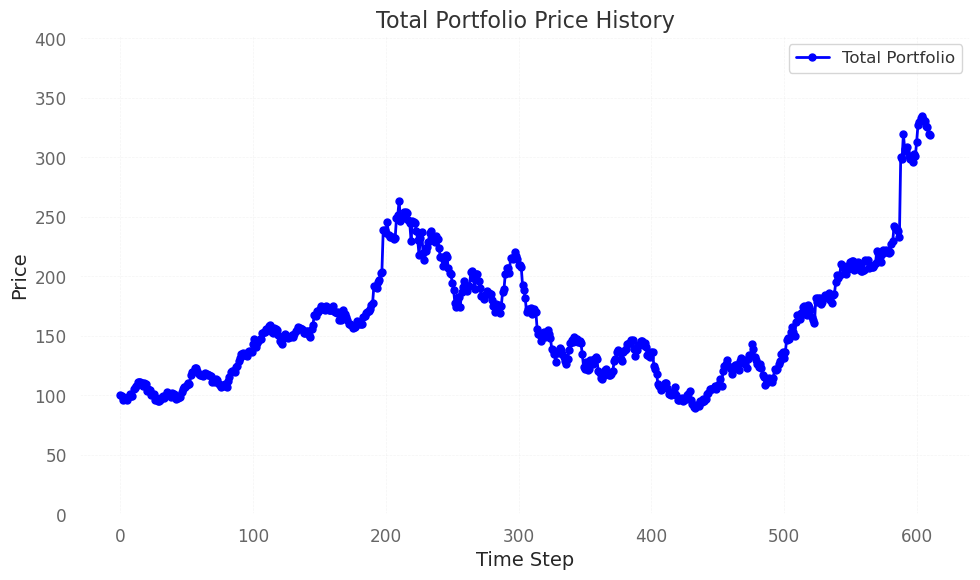

In [3]:
from collections import Counter

# Initialize the environment and variables
observation, info = envs[0].reset(seed=SEED)
total_reward = 0
has_policy = False

while True:
    actions = []
    # Get actions from models
    if has_policy:
        actions.append(int(models[0].policy.predict(observation, deterministic=True)[0]))
        for i in range(1,len(history_length)):
            actions.append(int(models[i].policy.predict(observation[-(envs[i].ColSize*envs[i].num_stocks*envs[i].history_length):], deterministic=True)[0]))
    else:
        actions.append(int(models[0].predict(observation, deterministic=True)[0]))
        for i in range(1,len(history_length)):
            actions.append(int(models[i].predict(observation[-(envs[i].ColSize*envs[i].num_stocks*envs[i].history_length):], deterministic=True)[0]))

    # Convert actions to hashable types (e.g., integers or tuples)
    action = Counter(actions).most_common(1)[0][0]
    print(actions,action)

    # Step in the environment
    observation, reward, done, _, _ = envs[0].step(action)

    # Accumulate total reward
    total_reward += reward

    if done:
        break
_ = envs[0].returns()
print(f"Total reward: {total_reward}")
envs[0].render('total')

[3, 4, 3, 4] 3
[3, 5, 5, 6] 5
[4, 3, 4, 6] 4
[4, 4, 4, 4] 4
[2, 4, 4, 4] 4
[0, 3, 4, 6] 0
[4, 3, 3, 6] 3
[4, 3, 3, 6] 3
[4, 5, 3, 6] 4
[5, 4, 4, 4] 4
[4, 4, 4, 4] 4
[5, 4, 4, 6] 4
[1, 2, 3, 6] 1
[1, 5, 1, 6] 1
[1, 5, 1, 6] 1
[1, 5, 1, 6] 1
[1, 5, 1, 6] 1
[1, 2, 3, 6] 1
[1, 5, 1, 6] 1
[1, 5, 1, 6] 1
[1, 5, 1, 6] 1
[1, 5, 1, 1] 1
[1, 5, 1, 6] 1
[1, 5, 1, 6] 1
[1, 5, 4, 6] 1
[1, 4, 2, 4] 4
[1, 4, 4, 4] 4
[1, 4, 4, 4] 4
[4, 4, 2, 4] 4
[4, 4, 2, 4] 4
[4, 4, 2, 4] 4
[4, 4, 2, 4] 4
[1, 4, 2, 4] 4
[1, 4, 2, 6] 1
[3, 4, 2, 6] 3
[5, 4, 2, 6] 5
[0, 4, 4, 4] 4
[5, 4, 2, 6] 5
[0, 4, 4, 6] 4
[0, 4, 2, 6] 0
[0, 4, 2, 6] 0
[0, 4, 3, 6] 0
[5, 4, 4, 6] 4
[5, 5, 1, 6] 5
[5, 5, 2, 6] 5
[4, 5, 2, 6] 4
[5, 4, 1, 2] 5
[5, 4, 2, 4] 4
[0, 4, 2, 4] 4
[0, 4, 2, 4] 4
[4, 4, 4, 4] 4
[4, 4, 4, 4] 4
[0, 4, 4, 4] 4
[0, 4, 2, 4] 4
[0, 4, 2, 4] 4
[4, 4, 2, 4] 4
[4, 4, 2, 4] 4
[4, 4, 2, 4] 4
[4, 4, 2, 4] 4
[4, 4, 2, 4] 4
[0, 4, 2, 4] 4
[0, 4, 2, 4] 4
[0, 4, 2, 4] 4
[0, 4, 2, 4] 4
[0, 4, 2, 4] 4
[0, 4, 2, 4] 4
[0, 4, 4, 

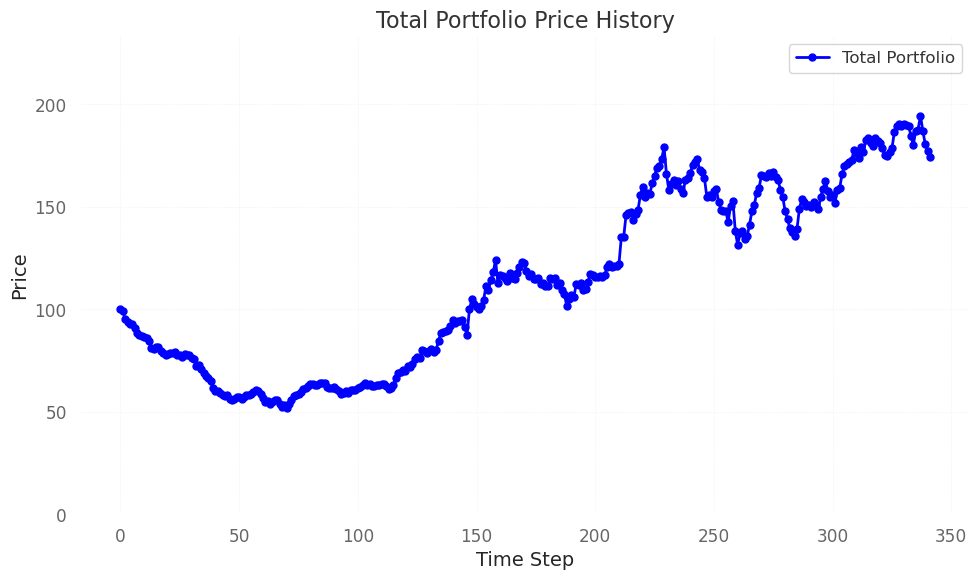

In [4]:
# Initialize the environment and variables
observation, info = test_env.reset(seed=SEED)
total_reward = 0
has_policy = False

while True:
    actions = []
    # Get actions from models
    if has_policy:
        actions.append(int(models[0].policy.predict(observation, deterministic=True)[0]))
        for i in range(1,len(history_length)):
            actions.append(int(models[i].policy.predict(observation[-(envs[i].ColSize*envs[i].num_stocks*envs[i].history_length):], deterministic=True)[0]))
    else:
        actions.append(int(models[0].predict(observation, deterministic=True)[0]))
        for i in range(1,len(history_length)):
            actions.append(int(models[i].predict(observation[-(envs[i].ColSize*envs[i].num_stocks*envs[i].history_length):], deterministic=True)[0]))

    # Convert actions to hashable types (e.g., integers or tuples)
    action = Counter(actions).most_common(1)[0][0]
    print(actions,action)

    # Step in the environment
    observation, reward, done, _, _ = test_env.step(action)

    # Accumulate total reward
    total_reward += reward

    if done:
        break
_ = test_env.returns()
print(f"Total reward: {total_reward}")
test_env.render('total')